<a href="https://colab.research.google.com/github/Seiko-5/NLP/blob/main/Visual_Impairment_and_Blindness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use of Advanced NLP Techniques to Analyse the data

## 01. Loading Libraries



In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 7.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 39.5 MB/s 
     |████████████████████████████████| 15.7 MB 194 kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=29474f83a054ee6939f0b778a5b899720a30a5e00c57905da064d55f292e19d5
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take int

In [ ]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import files

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
#import pyLDAvis.gensim

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#load in the sentiment analyzer
sia=SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 02. Load Data

In [ ]:
df= pd.read_excel ('/content/INPUT DATA-Final.xlsx')

## 03. Preliminary Analysis

### 03.01. SUMMSUMMARY OF THE DATA SET

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NAME    1232 non-null   object
 1   TEXT    1232 non-null   object
dtypes: object(2)
memory usage: 19.4+ KB


### 03.02. WORD COUNT


In [ ]:
def word_counter(document):
  split_word = str(document).split(" ") # split by white space
  word_count = len(split_word) # count the words
  return word_count

df['word_count_function'] = df['TEXT'].apply(word_counter)

In [ ]:
df.head(5)

,NAME,TEXT,word_count_function
0,CHAMINDA,I am not I am just playing some music in my k...,13
1,CHAMINDA,Yes s little bit,4
2,CHAMINDA,I just play the keyboard when I am free,11
3,CHAMINDA,No its OK I can talk with you now,9
4,CHAMINDA,never mind,3


Same above function can be achieved through a simple lambda function.

In [ ]:
df['word_count'] = df['TEXT'].apply(lambda x: len(str(x).split(" ")))
df.head(5)

,NAME,TEXT,word_count_function,word_count
0,CHAMINDA,I am not I am just playing some music in my k...,13,13
1,CHAMINDA,Yes s little bit,4,4
2,CHAMINDA,I just play the keyboard when I am free,11,11
3,CHAMINDA,No its OK I can talk with you now,9,9
4,CHAMINDA,never mind,3,3


### 03.03.CHARACCHARACTER COUNT

In [ ]:
df['char_count'] = df['TEXT'].str.len()  # Includes the spaces
df.head(5)

,NAME,TEXT,word_count_function,word_count,char_count
0,CHAMINDA,I am not I am just playing some music in my k...,13,13,53
1,CHAMINDA,Yes s little bit,4,4,16
2,CHAMINDA,I just play the keyboard when I am free,11,11,41
3,CHAMINDA,No its OK I can talk with you now,9,9,33
4,CHAMINDA,never mind,3,3,11


### 03.04. AVARAGE WORD LENGTH 




In [ ]:
def avg_word(sentence):
  words = sentence.split() # split the sentence into words
  avg_of_words = (sum(len(word) for word in words)/len(words))
  return avg_of_words

df['avg_word'] = df['TEXT'].apply(avg_word)
df.head(5)

,NAME,TEXT,word_count_function,word_count,char_count,avg_word
0,CHAMINDA,I am not I am just playing some music in my k...,13,13,53,3.416667
1,CHAMINDA,Yes s little bit,4,4,16,3.250000
2,CHAMINDA,I just play the keyboard when I am free,11,11,41,3.444444
3,CHAMINDA,No its OK I can talk with you now,9,9,33,2.777778
4,CHAMINDA,never mind,3,3,11,4.500000


## 04. Preprocessing

### 04.01.  Transform sentences into lowercase

In [ ]:
df['TEXT'] = df['TEXT'].str.lower()

In [ ]:
# Following command is just to visualize the processed dataframe
df.tail()

,NAME,TEXT,word_count_function,word_count,char_count,avg_word
1227,KAMAL,if the disability management center do not pay...,19,19,122,5.473684
1228,KAMAL,they are unable to support to the person with...,17,17,97,5.062500
1229,KAMAL,because they are unaware of our needs,8,8,38,4.428571
1230,KAMAL,as a result of that they easily forgot us,10,10,42,3.666667
1231,KAMAL,now we faced a lot of difficulties because of...,12,12,58,4.272727


Remove twitter user ids that are mentioned in the tweet text. We will use regular expressions(https://www.w3schools.com/python/python_regex.asp) to do this.
In applying the regular expression, we use the string in the format r"regular-expression". This is to treat the regex as a raw string. Additional information on this can be found from this stackoverflow question(https://stackoverflow.com/questions/4780088/what-does-preceding-a-string-literal-with-r-mean).

In [ ]:
def remove_twitter_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) # remove multiple spaces
  return spaces_removed

df['TEXT'] = df['TEXT'].apply(remove_twitter_ids)
df.tail()

,NAME,TEXT,word_count_function,word_count,char_count,avg_word
1227,KAMAL,if the disability management center do not pay...,19,19,122,5.473684
1228,KAMAL,they are unable to support to the person with...,17,17,97,5.062500
1229,KAMAL,because they are unaware of our needs,8,8,38,4.428571
1230,KAMAL,as a result of that they easily forgot us,10,10,42,3.666667
1231,KAMAL,now we faced a lot of difficulties because of...,12,12,58,4.272727


In [ ]:
# How does above function works?
# Take any tweet that has mentions in it. e.g., https://twitter.com/DavidLKeating/status/1251253645431144457
twt = "Canada just ordered #masks4all for flights. We need this on all US flights NOW. What are we waiting for @SecElaineChao @AmericanAir @Delta @SouthwestAir @united @AlaskaAir @FAANews ??? @jeremyphoward update"
out_twt = remove_twitter_ids(twt)
print(out_twt)

Canada just ordered masks4all for flights We need this on all US flights NOW What are we waiting for update


### 04.02 Duplicate removal

In [ ]:
# Check duplicate tweets count
duplicate_count = len(df1['CONTENT'])-len(df1['CONTENT'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df1.shape[0])

NameError: ignored

### 04.03 Stop words and domain related word removal

In [ ]:
#Remove stop words
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# get the list of all stopwords from the library
stop = stopwords.words('english')

In [ ]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

removing the term 'not' from the stopword list for analysis.

In [ ]:
stop.remove('not')

In [ ]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [ ]:
# Remove the words in 'stop' list
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
df['TEXT'] = df['TEXT'].apply(remove_stop_words)
df.tail(5)

,NAME,TEXT,word_count_function,word_count,char_count,avg_word
1227,KAMAL,disability management center not pay attention...,19,19,122,5.473684
1228,KAMAL,unable support person visual impairment real d...,17,17,97,5.062500
1229,KAMAL,unaware needs,8,8,38,4.428571
1230,KAMAL,result easily forgot us,10,10,42,3.666667
1231,KAMAL,faced lot difficulties reason,12,12,58,4.272727


### 04.04 Remove digits

In [ ]:
def remove_digits(sent):
  return " ".join(w for w in sent.split() if not w.isdigit())

df['TEXT'] = df['TEXT'].apply(remove_digits)
df.head()

,NAME,TEXT,word_count_function,word_count,char_count,avg_word
0,CHAMINDA,not playing music keyboard,13,13,53,3.416667
1,CHAMINDA,yes little bit,4,4,16,3.250000
2,CHAMINDA,play keyboard free,11,11,41,3.444444
3,CHAMINDA,ok talk,9,9,33,2.777778
4,CHAMINDA,never mind,3,3,11,4.500000


### 04.05 Spelling correction



To correct misspelt words, we will use [textblob library](https://textblob.readthedocs.io/en/dev/) library. Keep in mind that corrections are always bound by the dictionary that you would use, and it may not account for context (their vs there).

Due to the time complexity of spell-checking an entire corpus, in this exercise, we will use spell-check for just one example. 

In [ ]:
from textblob import TextBlob

In [ ]:
# Do not run this line of code.
# Following line of code will correct spellings of all the sentences in the dataset.
#df['sentence'] = df['sentence'].apply(lambda x: str(TextBlob(x).correct()))   # This will take a long time. Thus, we will show an seperate example

Spelling correction example

In [ ]:
def correct_word(word):
  return str(TextBlob(word).correct())

print(correct_word('bisness'))

business


In [ ]:
incorrect_text = 'bisness anlytis is an itant skil seit for any organizaton'

func = lambda x: str(TextBlob(x).correct())
print(incorrect_text)
print(str(TextBlob(incorrect_text).correct()))

bisness anlytis is an itant skil seit for any organizaton
business analysis is an want skin set for any organization


In [ ]:
print(X_bow)

In the feature vector row (e.g., (0, 4843)), the first digit refers to the sentence row (i.e., first datarow).  
The second digit is the index of alphebitically ordered word list.

## 05. Standardization of sentesentences 

### Stemming

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

df['TEXT_stem'] = df['TEXT'].apply(stemming_function)

In [ ]:
# Compare the content vs. stemmed content
df[['TEXT', 'TEXT_stem']].tail(10)

,TEXT,TEXT_stem
1222,disaster really taken place officers easily lo...,disast realli taken place offic easili look pe...
1223,officers know many persons visual impairment a...,offic know mani person visual impair area incharg
1224,nature disaster different one another,natur disast differ one anoth
1225,flood different current situation covid pandemic,flood differ current situat covid pandem
1226,therefore measures taken accordingly,therefor measur taken accordingli
1227,disability management center not pay attention...,disabl manag center not pay attent person visu...
1228,unable support person visual impairment real d...,unabl support person visual impair real disast...
1229,unaware needs,unawar need
1230,result easily forgot us,result easili forgot us
1231,faced lot difficulties reason,face lot difficulti reason


### Lemmatization



In [ ]:
# Download wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmtizer = WordNetLemmatizer()

In [ ]:
def lemmatize_function(sent):
  word_list = sent.split()
  lemma_word_list = [lemmtizer.lemmatize(word) for word in word_list]
  lemma_sentence = " ".join(lemma_word_list)
  return lemma_sentence

df['TEXT_lemmatized'] = df['TEXT'].apply(lemmatize_function)

Display original pre-processed sentence, stemmed sentence and lemmatized sentence.

In [ ]:
df[['TEXT', 'TEXT_stem', 'TEXT_lemmatized']].tail(10)

,TEXT,TEXT_stem,TEXT_lemmatized
1222,disaster really taken place officers easily lo...,disast realli taken place offic easili look pe...,disaster really taken place officer easily loo...
1223,officers know many persons visual impairment a...,offic know mani person visual impair area incharg,officer know many person visual impairment are...
1224,nature disaster different one another,natur disast differ one anoth,nature disaster different one another
1225,flood different current situation covid pandemic,flood differ current situat covid pandem,flood different current situation covid pandemic
1226,therefore measures taken accordingly,therefor measur taken accordingli,therefore measure taken accordingly
1227,disability management center not pay attention...,disabl manag center not pay attent person visu...,disability management center not pay attention...
1228,unable support person visual impairment real d...,unabl support person visual impair real disast...,unable support person visual impairment real d...
1229,unaware needs,unawar need,unaware need
1230,result easily forgot us,result easili forgot us,result easily forgot u
1231,faced lot difficulties reason,face lot difficulti reason,faced lot difficulty reason


Lemmatized algorithm seems to be working better in this case.


## 06. Common and rare word analysis (Word Frequency Analysis)

### 06.01 Common Words

In [ ]:
# Create a word frequency series. 
word_frequency = pd.Series(' '.join(df['TEXT_lemmatized']).split()).value_counts()

In [ ]:
# Look at the top 50 words 
word_frequency[:50]

not             124
people          122
go               86
get              80
blind            79
person           73
thing            68
also             67
one              55
day              54
time             54
need             53
problem          51
like             51
yes              50
visual           46
u                44
situation        43
student          41
home             38
buy              36
impairment       35
help             34
job              33
government       32
cannot           31
could            30
impaired         30
know             30
organization     29
work             29
lot              27
money            26
month            26
many             24
school           24
way              23
visually         23
child            23
item             23
sell             23
food             23
didnt            23
difficult        22
place            22
good             21
teacher          21
curfew           20
see              20
wife             20


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


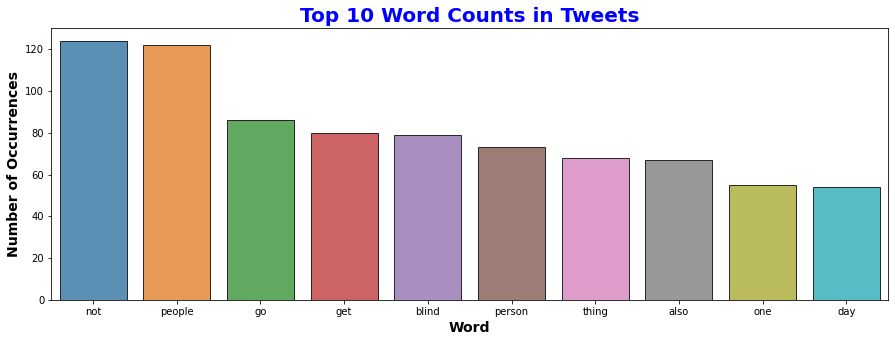

In [ ]:
# Visualize the top 10 word counts 

word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8,edgecolor = 'black')

plt.title('Top 10 Word Counts in Tweets',fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Occurrences', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.xlabel('Word', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.show()

We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words in 4

In [ ]:
from PIL import Image
from wordcloud import WordCloud

### 06.02. Remove common words

In [ ]:
# Creating a list of custom stopwords
new_words_to_remove = ["go", "get", "blind","also","one","day","time","visual", "u","yes","impairment","impaired","visually","month","didnâ€™t","thing","know","two","r","wife","yes","therefoe","even","done","around","got"]

In [ ]:
# Remove common Tweet
df['TEXT_lemmatized'] = df['TEXT_lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(5)

,NAME,TEXT,word_count_function,word_count,char_count,avg_word,TEXT_stem,TEXT_lemmatized
0,CHAMINDA,not playing music keyboard,13,13,53,3.416667,not play music keyboard,not playing music keyboard
1,CHAMINDA,yes little bit,4,4,16,3.250000,ye littl bit,little bit
2,CHAMINDA,play keyboard free,11,11,41,3.444444,play keyboard free,play keyboard free
3,CHAMINDA,ok talk,9,9,33,2.777778,ok talk,ok talk
4,CHAMINDA,never mind,3,3,11,4.500000,never mind,never mind


In [ ]:
# Create a word frequency series. 
word_frequency = pd.Series(' '.join(df['TEXT_lemmatized']).split()).value_counts()

In [ ]:
# Look at the top 50 words
word_frequency[:50]

not             124
people          122
person           73
need             53
like             51
problem          51
situation        43
student          41
home             38
buy              36
help             34
job              33
government       32
cannot           31
could            30
organization     29
work             29
lot              27
money            26
many             24
school           24
item             23
food             23
child            23
sell             23
way              23
didnt            23
difficult        22
place            22
good             21
teacher          21
see              20
curfew           20
queue            19
make             19
medicine         19
support          18
daily            18
hand             18
face             18
long             18
house            17
shop             17
bank             17
disability       17
town             17
education        17
may              16
special          16
sometimes        16


In [ ]:
# Save the pre-process data
#df.to_csv('Preprocess_Tweets.csv')

### 06.03.Word Cloud

In this Word Cloud frequency of all the worlds were taken in to consideration.

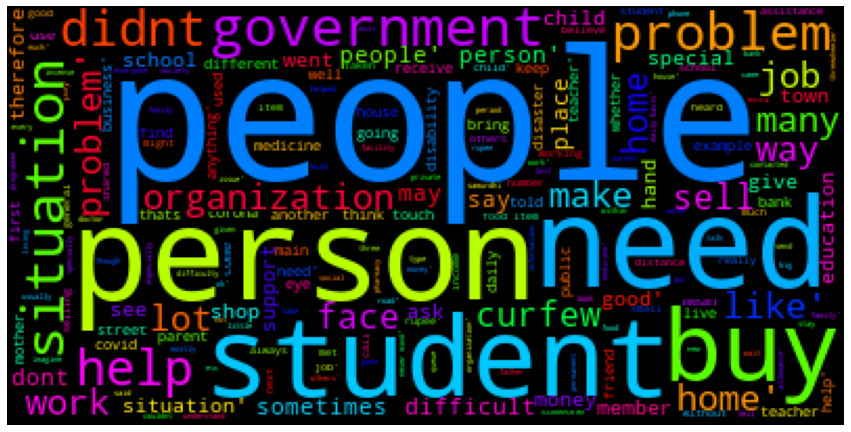

In [ ]:
corpus = list(df['TEXT_lemmatized'])

wordcloud = WordCloud(background_color='black',colormap="hsv",
                      random_state=42).generate(str(corpus))

fig = plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('Word_Cloud_01.png', dpi=800)
#files.download('Word_Cloud_01.png')
plt.show()

### 06.04. Rare Words


word_frequency[-50:]

### 06.05. Remove Rare words

In [ ]:
# Creating a list of custom stopwords
new_words_to_remove = ["online", "learning ", "onlinelearning","learning","elearning"]

In [ ]:
# Remove common Tweet
df1['CONTENT_lemmatized'] = df1['CONTENT_lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df1.head(5)

,date,tweet,place,tweet_stem,tweet_lemmatized
0,2020-06-01,total lack investment regarding online learnin...,NaN,total lack invest regard onlin learn doubt mea...,total lack investment regarding doubt mean sec...
1,2020-06-01,second part blog series south africa opportuni...,NaN,second part blog seri south africa opportun hy...,second part blog series south africa opportuni...
2,2020-06-01,even private schools cant online learning,NaN,even privat school cant onlin learn,even private school cant
3,2020-06-01,creating powerful learning experiences google ...,NaN,creat power learn experi googl classroom tech ...,creating powerful experience google classroom ...
4,2020-06-01,normal provide cost effective baby sitters unl...,NaN,normal provid cost effect babi sitter unless w...,normal provide cost effective baby sitter unle...


In [ ]:
# Create a word frequency series. 
word_frequency = pd.Series(' '.join(df1['CONTENT_lemmatized']).split()).value_counts()

In [ ]:
# Look at the top 50 words
word_frequency[:50]

student       6755
school        5133
not           3709
education     3623
course        2890
teacher       2650
new           2311
u             2284
class         2245
time          2179
free          2007
learn         1999
year          1988
covid19       1909
need          1840
kid           1726
work          1717
get           1714
week          1670
today         1618
help          1610
one           1549
home          1512
teaching      1488
like          1467
im            1439
day           1408
dont          1375
may           1338
child         1308
make          1289
access        1275
university    1275
great         1261
parent        1225
support       1202
experience    1171
resource      1133
video         1131
know          1129
way           1128
read          1111
well          1107
training      1041
many          1036
take          1031
platform      1020
via           1016
virtual       1013
go             972
dtype: int64

## 07.Save the pre-process data


In [ ]:
df1.to_csv('Preprocess_Tweets.csv')

## 08. Bag of words



[Bag of words](https://machinelearningmastery.com/gentle-introduction-bag-words-model/) is a simple text feature extraction mechanism.   
A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:
* A vocabulary of known words.  
* A measure of the presence of known words.  

We will use [CountVectorizer library](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) on sklearn for bag-of-words model creation.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

You may refer to [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) API for detailed description about the parameters.

In [ ]:
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1), analyzer = "word")

Transform lemmatized senteces into bag-of-words model.

In [ ]:
X_bow = bow.fit_transform(df['TEXT_lemmatized'])

The X_bow would result in a term-document matrix.  
e.g., Output format:  (sentence_id, vocabulary_dictionary_id) count
* sentence_id - sentence id in the dataframe
* vocabulary_dictionary_id - id of the particular word in the bag of words model dictionary
* count - count of words

In [ ]:
df['TEXT_lemmatized'].head()

0    not playing music keyboard
1                    little bit
2            play keyboard free
3                       ok talk
4                    never mind
Name: TEXT_lemmatized, dtype: object

## 09. Term Frequency - Inverse Document Frequecy (TF-IDF)



[Term frequency–inverse document frequency](https://www.kdnuggets.com/2018/08/wtf-tf-idf.html), is a numerical statistic that is intended to reflect how important a word is to a document in a collection. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

We will use [feature extraction module](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) of the sklearn library for this.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

Construct TF-IDF using the lemmatized senteces.

In [ ]:
tf_idf = vectorizer.fit_transform(df['TEXT_lemmatized'])  # as the text data, we will use lemmatized sentences

Display the list of all the words.

In [ ]:
print(vectorizer.get_feature_names())

['11th', '17th', '1o', '9th', 'able', 'accept', 'acceptable', 'accidently', 'accompanied', 'according', 'accordingly', 'accustomed', 'action', 'actively', 'activity', 'actually', 'adapt', 'addition', 'address', 'adhara', 'adjust', 'administer', 'admit', 'admitted', 'advanced', 'affair', 'affairswith', 'affect', 'affected', 'affecting', 'affluent', 'afford', 'afraid', 'afternoon', 'afterwards', 'ago', 'ah', 'aha', 'ahangama', 'aim', 'allovence', 'allow', 'allowance', 'allowed', 'alone', 'along', 'already', 'alternative', 'always', 'among', 'amount', 'angry', 'annual', 'annually', 'another', 'anuradhapura', 'anything', 'anyway', 'anywhere', 'apart', 'app', 'appears', 'april', 'aradana', 'area', 'areamuch', 'armed', 'arrange', 'arranged', 'arrangement', 'article', 'ask', 'asked', 'asking', 'asks', 'aspect', 'assembly', 'assist', 'assistance', 'assisting', 'associate', 'associated', 'association', 'attach', 'attached', 'attend', 'attention', 'aunt', 'authority', 'available', 'average', 'aw

Here you see there are quite many text that includes a number (digit).  
In one of the pre-processing steps, we removed all the words/text that are only digits, but not combined.  
You might want to remove these as well...  

A comparison of TF-IDF values with respect to lemmatized sentences.

In [ ]:
print(df['TEXT_lemmatized'].head())

0    not playing music keyboard
1                    little bit
2            play keyboard free
3                       ok talk
4                    never mind
Name: TEXT_lemmatized, dtype: object


In [ ]:
print(tf_idf[:5])

  (0, 673)	0.5243613469102428
  (0, 817)	0.5981911872707513
  (0, 948)	0.5423410690638307
  (0, 848)	0.2703306237642825
  (1, 136)	0.7643965275210503
  (1, 716)	0.6447464220247835
  (2, 496)	0.5752351297161833
  (2, 947)	0.5998209295836223
  (2, 673)	0.5561649017816973
  (3, 1255)	0.6936712331048971
  (3, 872)	0.7202917605822876
  (4, 792)	0.6857612483586963
  (4, 838)	0.727826566050953


## 10. Bigrams and Trigrams

### Bigrams

In [ ]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):
    
    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create bag of word feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [ ]:
bigrams_covid = get_ngrams(df['TEXT_lemmatized'].tolist(), ngram_range=(2, 2))


Convert bigrams of datasets to a dataframe with column names bi-gram and frequency.

In [ ]:
bigrams_covid_df = pd.DataFrame(bigrams_covid)
bigrams_covid_df.columns=["Bi-gram", "Freq"]

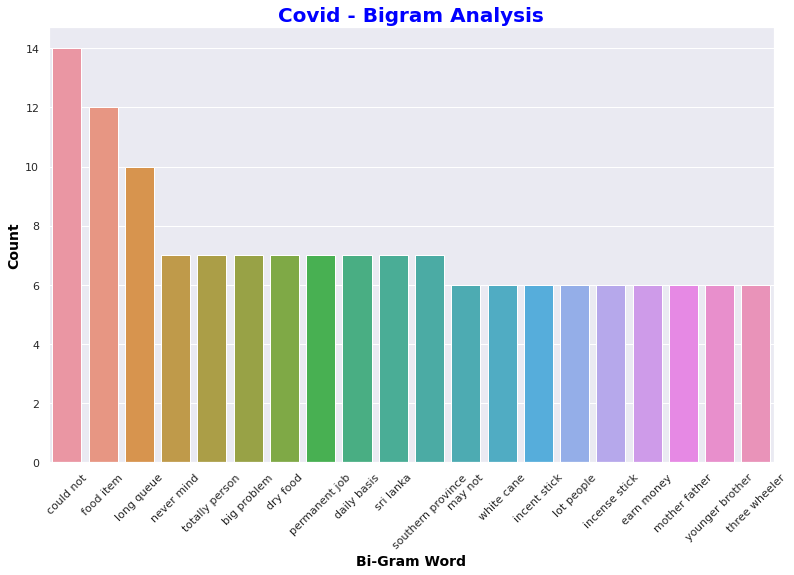

In [ ]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot( x="Bi-gram", y="Freq",data=bigrams_covid_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)  # here rotation parameter shows the angle of your x-axis labels

plt.title('Covid - Bigram Analysis', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Bi-Gram Word', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Count', fontweight='bold', color = 'black', fontsize='14')  
#plt.savefig('Covid_Bigram_Analysis.png', dpi=800)
#files.download('Covid_Bigram_Analysis.png')
plt.show()

**Analysing Special worlds uisng Bigrams**

In [ ]:
new_bigrams_covid_df= pd.concat([bigrams_covid_df['Bi-gram'].str.split(' ', expand=True)], axis=1)
new_bigrams_covid_df.columns=["word1", "word2"]

In [ ]:
#Bigrams related to "lockdown" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'lockdown']

,word1,word2


### Trigrams

In [ ]:
#Most frequently occuring Tri-grams
def get_trigrams(corpus):
    vec1 = CountVectorizer(ngram_range=(3,3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [ ]:
trigrams_covid = get_ngrams(df['TEXT_lemmatized'].tolist(), ngram_range=(3, 3))

In [ ]:
trigrams_covid_df = pd.DataFrame(trigrams_covid)
trigrams_covid_df.columns=["Tri-gram", "Freq"]

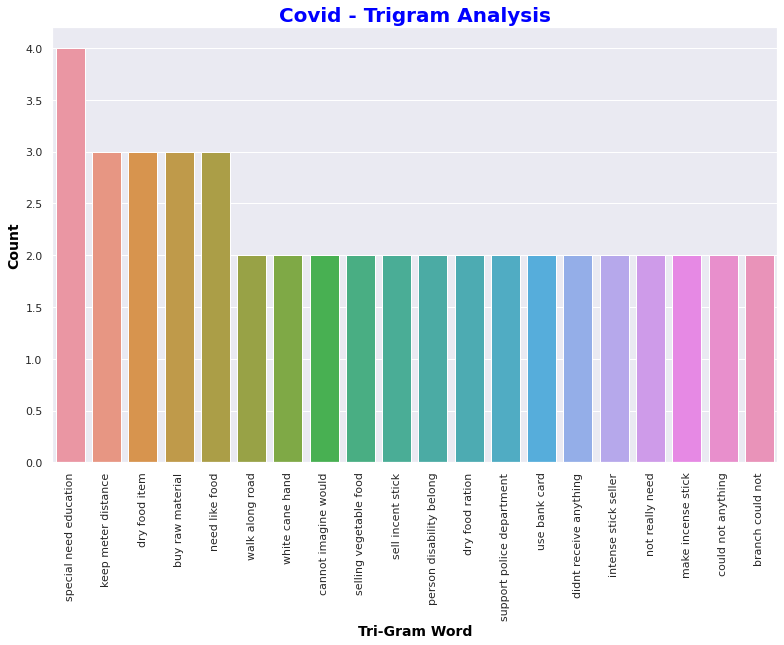

In [ ]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_covid_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)

plt.title('Covid - Trigram Analysis', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Tri-Gram Word', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Count', fontweight='bold', color = 'black', fontsize='14')  
#plt.savefig('Covid_Trigram_Analysis.png', dpi=800)
#files.download('Covid_Trigram_Analysis.png')
plt.show()

**Analysing Special worlds uisng Trigrams**

In [ ]:
new_trigrams_covid_df= pd.concat([trigrams_covid_df['Tri-gram'].str.split(' ', expand=True)], axis=1)
new_trigrams_covid_df.columns=["word1", "word2","word3"]

In [ ]:
#Trigrams related to "not" term
new_trigrams_covid_df.loc[new_trigrams_covid_df['word1'] == 'not']

,word1,word2,word3
12,not,want,show
100,not,put,shopsthose
122,not,packed,put
176,not,take,medicine
285,not,enough,itis
309,not,get,anything
322,not,hold,meeting
508,not,received,anything
625,not,problemsocial,distance
636,not,save,distancethats


## 11. Sentiment Analysis

### 11.01. Polarity

In [ ]:
# Extract sentiments from the tweets using polarity
df['polarity'] = df['TEXT_lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity)


### 11.02. Subjectivity

In [ ]:
# Extract sentiments from the tweets using subjectivity
df['subjectivity'] = df['TEXT_lemmatized'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

### 11.03.VADER

In [ ]:
# Extract sentiments from the tweets using VADER
df['VADER'] =df['TEXT_lemmatized'].apply(lambda x: sia.polarity_scores(x)['compound'])

### 11.04. Display sentaences with respective sentiment value

In [ ]:

df[['TEXT_lemmatized', 'polarity','subjectivity', 'VADER']].head(10)


,TEXT_lemmatized,polarity,subjectivity,VADER
0,not playing music keyboard,0.0000,0.00,-0.1511
1,little bit,-0.1875,0.50,0.0000
2,play keyboard free,0.4000,0.80,0.6908
3,ok talk,0.5000,0.50,0.2960
4,never mind,0.0000,0.00,0.0000
5,never mind,0.0000,0.00,0.0000
6,happy discus,0.8000,1.00,0.5719
7,never mind,0.0000,0.00,0.0000
8,totally teacher,0.0000,0.75,0.0000
9,graduate teacher,0.0000,0.00,0.0000


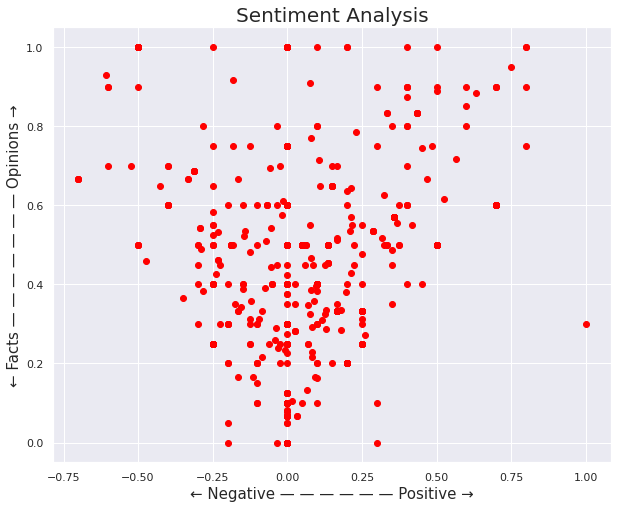

In [ ]:
# Let’s plot the results of polarity and Subjectivity together. 

plt.rcParams['figure.figsize'] = [10, 8]
for index, tweet_lemmatized in enumerate(df.index):
 x = df.polarity.loc[tweet_lemmatized]
 y = df.subjectivity.loc[tweet_lemmatized]
 plt.scatter(x, y, color='Red')
 
 
plt.title('Sentiment Analysis', fontsize = 20)
plt.xlabel('← Negative — — — — — — Positive →', fontsize=15)
plt.ylabel('← Facts — — — — — — — Opinions →', fontsize=15)
plt.show()



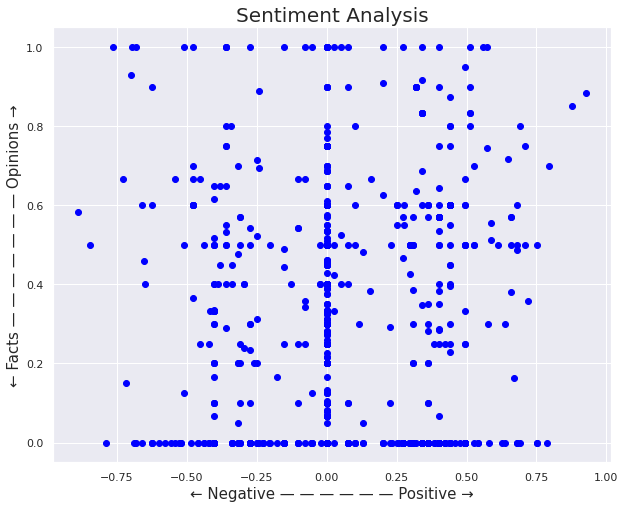

In [ ]:
# Let’s plot the results of VADER and Subjectivity together. 

plt.rcParams['figure.figsize'] = [10, 8]
for index, tweet_lemmatized in enumerate(df.index):
 x = df.VADER.loc[tweet_lemmatized]
 y = df.subjectivity.loc[tweet_lemmatized]
 plt.scatter(x, y, color='Blue')
 
 
plt.title('Sentiment Analysis', fontsize = 20)
plt.xlabel('← Negative — — — — — — Positive →', fontsize=15)
plt.ylabel('← Facts — — — — — — — Opinions →', fontsize=15)
plt.show()

In [ ]:
# Creating function for calculating positive, negative and neutral using polarity

def ratio(x):  
  if x > 0.5:
   return 'Extream Positive'
  elif x > 0:
   return 'Positive'
  elif x == 0:
   return 'Neutral'
  elif x > -0.50:
   return 'Negative'
  else:
   return 'Extream Negative'

df['Sentiment1'] = df['polarity'].apply(ratio)

In [ ]:
#Count of sentiments

df['Sentiment1'].value_counts()

Neutral             811
Positive            234
Negative            134
Extream Positive     27
Extream Negative     26
Name: Sentiment1, dtype: int64

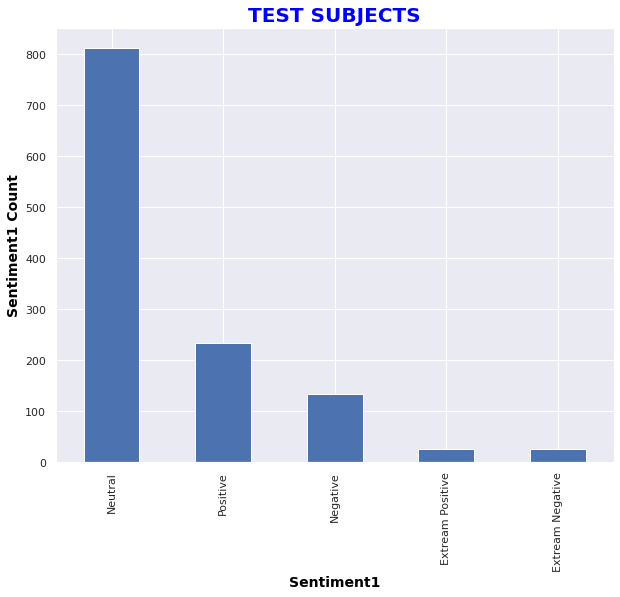

In [ ]:
#Plotting Sentiments

df['Sentiment1'].value_counts().plot(kind = 'bar')

plt.title('TEST SUBJECTS', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Sentiment1', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Sentiment1 Count', fontweight='bold', color = 'black', fontsize='14')  


#plt.savefig('Sentiment_Analysis2.png', dpi=800)
#files.download('Sentiment_Analysis2.png')
plt.show()


In [ ]:
# Creating function for calculating positive, negative and neutral using VADER

def ratio(x):  
  if x > 0.5:
   return 'Extream Positive'
  elif x > 0:
   return 'Positive'
  elif x == 0:
   return 'Neutral'
  elif x > -0.50:
   return 'Negative'
  else:
   return 'Extream Negative'

df['Sentiment2'] = df['VADER'].apply(ratio)

In [ ]:
#Count of sentiments

df['Sentiment2'].value_counts()

Neutral             738
Positive            246
Negative            172
Extream Positive     45
Extream Negative     31
Name: Sentiment2, dtype: int64

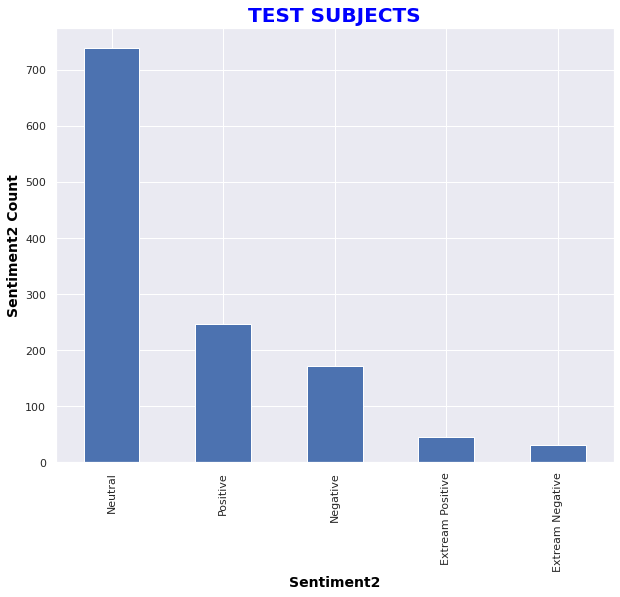

In [ ]:
#Plotting Sentiments

df['Sentiment2'].value_counts().plot(kind = 'bar')

plt.title('TEST SUBJECTS', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Sentiment2', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Sentiment2 Count', fontweight='bold', color = 'black', fontsize='14')  


#plt.savefig('Sentiment_Analysis2.png', dpi=800)
#files.download('Sentiment_Analysis2.png')
plt.show()


## 12.Topic Modeling

### 12.01. Setting up the environment for LDA algorithm.

In [ ]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


Now we will create the text corpus.

In [ ]:
# Convert the tweets as the text corpus.
corpus = list(df['TEXT_lemmatized'])

In [ ]:
# Tokanization
covid_texts = [[word for word in str(document).split()] for document in corpus]

In [ ]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(covid_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'covid.dict'))

2021-01-24 01:38:00,539 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-01-24 01:38:00,561 : INFO : built Dictionary(1430 unique tokens: ['keyboard', 'music', 'not', 'playing', 'bit']...) from 1232 documents (total 5339 corpus positions)
2021-01-24 01:38:00,563 : INFO : saving Dictionary object under /tmp/covid.dict, separately None
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
2021-01-24 01:38:00,569 : INFO : saved /tmp/covid.dict


In [ ]:
# Print the dictionary
print(dictionary.token2id)

{'keyboard': 0, 'music': 1, 'not': 2, 'playing': 3, 'bit': 4, 'little': 5, 'free': 6, 'play': 7, 'ok': 8, 'talk': 9, 'mind': 10, 'never': 11, 'discus': 12, 'happy': 13, 'teacher': 14, 'totally': 15, 'graduate': 16, 'anuradhapura': 17, 'live': 18, 'didnt': 19, 'major': 20, 'problem': 21, 'come': 22, 'curfew': 23, 'many': 24, 'seller': 25, 'week': 26, 'threewheeler': 27, 'cost': 28, 'drive': 29, 'person': 30, 'keeping': 31, 'travelling': 32, 'ask': 33, 'fetch': 34, 'good': 35, 'thats': 36, 'whenever': 37, 'came': 38, 'fruit': 39, 'home': 40, 'like': 41, 'house': 42, 'main': 43, 'mean': 44, 'road': 45, 'gas': 46, 'vegetable': 47, 'front': 48, 'doter': 49, 'mother': 50, 'family': 51, 'four': 52, 'member': 53, 'baby': 54, 'used': 55, 'vacation': 56, 'work': 57, 'working': 58, 'going': 59, 'see': 60, 'special': 61, 'every': 62, 'way': 63, 'garden': 64, 'maintaining': 65, 'chess': 66, 'cooking': 67, 'help': 68, 'meal': 69, 'sometimes': 70, 'internet': 71, 'surfing': 72, 'well': 73, 'board': 7

In [ ]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in covid_texts]

In [ ]:
# Corpus in machine readable format.
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 1)], [(0, 1), (6, 1), (7, 1)], [(8, 1), (9, 1)], [(10, 1), (11, 1)], [(10, 1), (11, 1)], [(12, 1), (13, 1)], [(10, 1), (11, 1)], [(14, 1), (15, 1)], [(14, 1), (16, 1)], [(17, 1), (18, 1)], [(19, 1), (20, 1), (21, 1)], [(22, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(27, 1)], [(28, 1), (29, 1), (30, 1)], [(31, 1), (32, 1)], [(23, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)], [(38, 1), (39, 1), (40, 1), (41, 1)], [(42, 1), (43, 1), (44, 1), (45, 1)], [(36, 1), (45, 1)], [(46, 1), (47, 1)], [(45, 1), (48, 1)], [(40, 1), (49, 1), (50, 1)], [(51, 1), (52, 1), (53, 1)], [(42, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)], [(2, 1), (50, 1), (59, 1), (60, 1), (61, 1)], [(34, 1), (35, 1), (62, 1)], [(2, 1), (34, 1), (35, 1), (59, 1), (63, 1)], [(64, 1), (65, 1)], [(3, 1), (49, 1), (66, 1), (67, 1), (68, 1), (69, 1)], [(0, 1), (3, 1), (70, 1)], [(71, 1), (72, 1), (73, 1)], [(74, 1), (75, 1), (76, 1)], [(74, 1), (77, 1), (78, 1)], [(79, 1), (

### 12.02. Generate the topic model

In [ ]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

2021-01-24 01:38:08,981 : INFO : collecting document frequencies
2021-01-24 01:38:08,985 : INFO : PROGRESS: processing document #0
2021-01-24 01:38:08,992 : INFO : calculating IDF weights for 1232 documents and 1429 features (5239 matrix non-zeros)


In [ ]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus]

### 12.03. Defining Topics Using LDA model

In [ ]:
total_topics = 10

In [ ]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2021-01-24 01:38:19,945 : INFO : using symmetric alpha at 0.1
2021-01-24 01:38:19,947 : INFO : using symmetric eta at 0.1
2021-01-24 01:38:19,949 : INFO : using serial LDA version on this node
2021-01-24 01:38:19,954 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 1232 documents, updating model once every 1232 documents, evaluating perplexity every 1232 documents, iterating 50x with a convergence threshold of 0.001000
2021-01-24 01:38:19,956 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.



In [ ]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=5)

[(0,
  '0.029*"people" + 0.013*"problem" + 0.012*"person" + 0.012*"child" + 0.012*"situation"'),
 (1,
  '0.019*"not" + 0.014*"people" + 0.010*"home" + 0.010*"sometimes" + 0.010*"organization"'),
 (2,
  '0.018*"not" + 0.016*"government" + 0.016*"difficult" + 0.011*"rupee" + 0.009*"could"'),
 (3,
  '0.024*"not" + 0.011*"house" + 0.010*"need" + 0.010*"curfew" + 0.009*"person"'),
 (4,
  '0.016*"problem" + 0.014*"three" + 0.012*"people" + 0.012*"ask" + 0.011*"earn"'),
 (5,
  '0.029*"person" + 0.021*"not" + 0.013*"ok" + 0.012*"see" + 0.011*"problem"'),
 (6,
  '0.037*"people" + 0.022*"not" + 0.012*"help" + 0.012*"situation" + 0.010*"much"'),
 (7,
  '0.019*"person" + 0.019*"people" + 0.016*"buy" + 0.015*"not" + 0.011*"school"'),
 (8,
  '0.036*"not" + 0.025*"like" + 0.024*"person" + 0.010*"people" + 0.009*"need"'),
 (9,
  '0.037*"people" + 0.022*"need" + 0.017*"not" + 0.017*"student" + 0.014*"problem"')]

### 12.04.Defining Topics Using NMF model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;

In [ ]:
from sklearn.preprocessing import normalize;

In [ ]:
from sklearn.decomposition import NMF;

In [ ]:
nmf_df = df['TEXT_lemmatized']

In [ ]:
#obtain a Counts design matrix. Because the size of the matrix will be large, we can set the max_features to 5000.
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
x_counts = vectorizer.fit_transform(nmf_df);

In [ ]:
#set a TfIdf transformer, and transfer the counts with the model.
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [ ]:
#normalize the TfIdf values so each row has unit length.
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [ ]:
#obtain a NMF model.
model = NMF(n_components=total_topics, init='nndsvd');

In [ ]:
#fit the model
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(total_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-6 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [ ]:
get_nmf_topics(model,6)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,not,ok,oh,problem,people,totally,year,way,mind,teacher
1,could,talk,impact,big,like,person,couldnt,sell,never,graduate
2,ask,job,house,main,cannot,isnt,mother,incense,come,help
3,follow,permanent,temple,eye,lot,im,studying,cant,biggest,example
4,disability,would,gatherand,face,job,husband,old,bring,concern,married
5,possible,student,coming,like,cant,job,father,buy,town,graduated


## 13. Interactive Topic Analyzer With LDA

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

2021-01-24 01:39:24,371 : INFO : NumExpr defaulting to 2 threads.


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      32.420952   8.115230       1        1  18.714438
4       0.648955  71.707100       2        1  17.261811
5      71.019684   9.971006       3        1  14.270375
9       3.785981  33.185135       4        1  13.879869
1     -42.666500  -9.222070       5        1   7.598359
8      -3.621689 -43.526516       6        1   7.349840
6      -3.632402  -4.171708       7        1   5.898029
3     -36.584400  35.804413       8        1   5.020033
0      44.391380  50.615383       9        1   5.004403
2      40.235809 -31.591665      10        1   5.002843, topic_info=        Term       Freq      Total Category  logprob  loglift
138   people  20.000000  20.000000  Default  30.0000  30.0000
30    person  14.000000  14.000000  Default  29.0000  29.0000
2        not  21.000000  21.000000  Default  28.0000  28.0000
41      like   8.000000   8.000000  Default  27.0000  27.0000
169     need   9.000000   9.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
30    person   0.337751  14.556833  Topic10  -5.2067  -0.7683
199      say   0.251636   2.787888  Topic10  -5.5010   0.5901
170   cannot   0.233997   6.209002  Topic10  -5.5737  -0.2833
127      job   0.228794   5.575433  Topic10  -5.5962  -0.1981
87   student   0.228793   8.598189  Topic10  -5.5962  -0.6313

[708 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
88        3  1.126503  according
850       3  1.222075     afford
358       2  0.348929  allowance
358       3  0.348929  allowance
33        2  0.730741        ask
...     ...       ...        ...
57        1  0.353883       work
57        3  0.176942       work
57        5  0.176942       work
57        6  0.176942       work
925       2  0.681104    younger

[330 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 6, 10, 2, 9, 7, 4, 1, 3])